In [23]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np 
from torch.optim import Adam
import matplotlib.pyplot as plt
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#### Implementation of the model
> Observation is a 4 dimensional vector <br>
> Action can be 0 or 1 (left or right), so the last output is 2 dimensional 

In [14]:
class CartPoleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Get probability distribution over actions
        return self.mlp(x)
    
    def get_actions(self, state):
        """ Sample an action based on the probability distribution

        *******
        PARAMS:
            state: 4x1 vector, state of the game
        OUTPUT:
            action (int) sampled from
            log probability of the action
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu() # probability vector
        m = Categorical(probs)
        action = m.sample() # sample an action from the probability distribution (proba vector)
        return action.item(), m.log_prob(action)

In [22]:
N_epoch = 500
env = gym.make("CartPole-v1", render_mode=None)
model_cartpole = CartPoleNN()
model_cartpole.to(device)

LR = 5e-3
optimizer = Adam(model_cartpole.parameters(), lr=LR)

gamma = 0.99
total_rewards = [0]*N_epoch

for epoch in range(N_epoch):
    terminated = False
    log_probabilities = [] # store probablities of actions for gradient computation
    rewards = []
    state = env.reset()[0]
    while not terminated:
        action, log_proba = model_cartpole.get_actions(state)
        state, reward, terminated, truncated, info = env.step(action)

        log_probabilities.append(log_proba)
        rewards.append(reward)
    
    total_rewards[epoch] = sum(rewards)
    if epoch % 9 == 0:
        print(f'Epoch {epoch}, total reward = {total_rewards[epoch]}')

    discounted_rewards = [0]*len(rewards)
    discounted_rewards[0] = sum((gamma**i)*rewards[i] for i in range(len(rewards)))
    for i in range(1,len(rewards)):
        discounted_rewards[i] = (discounted_rewards[i-1]-rewards[i-1])/gamma
    discounted_rewards = (discounted_rewards-np.mean(discounted_rewards))/len(discounted_rewards)
    discounted_rewards = torch.tensor(discounted_rewards)

    loss = []
    for log_prob, disc_return in zip(log_probabilities, discounted_rewards):
        loss.append(-log_prob * disc_return)
    loss = torch.cat(loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0, total reward = 16.0
Epoch 9, total reward = 16.0
Epoch 18, total reward = 12.0
Epoch 27, total reward = 17.0
Epoch 36, total reward = 45.0
Epoch 45, total reward = 36.0
Epoch 54, total reward = 84.0
Epoch 63, total reward = 86.0
Epoch 72, total reward = 99.0
Epoch 81, total reward = 49.0
Epoch 90, total reward = 163.0
Epoch 99, total reward = 197.0
Epoch 108, total reward = 232.0
Epoch 117, total reward = 75.0
Epoch 126, total reward = 383.0
Epoch 135, total reward = 330.0
Epoch 144, total reward = 199.0
Epoch 153, total reward = 501.0
Epoch 162, total reward = 1498.0
Epoch 171, total reward = 260.0
Epoch 180, total reward = 111.0
Epoch 189, total reward = 119.0
Epoch 198, total reward = 170.0
Epoch 207, total reward = 109.0
Epoch 216, total reward = 126.0
Epoch 225, total reward = 96.0
Epoch 234, total reward = 80.0
Epoch 243, total reward = 83.0
Epoch 252, total reward = 109.0
Epoch 261, total reward = 211.0
Epoch 270, total reward = 319.0
Epoch 279, total reward = 352.0
Epo

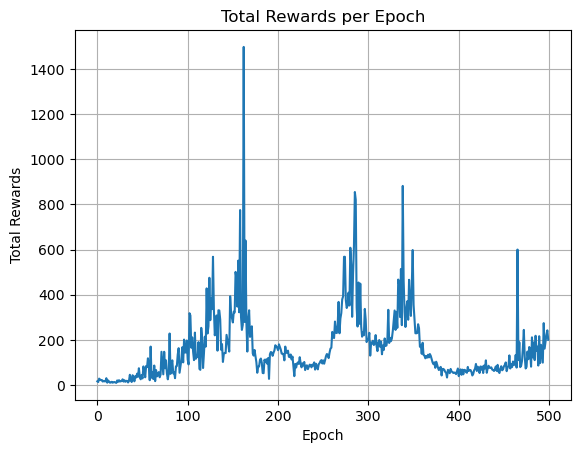

In [27]:
plt.plot(range(N_epoch), total_rewards)
plt.xlabel('Epoch')
plt.ylabel('Total Rewards')
plt.title('Total Rewards per Epoch')
plt.grid(True)
plt.savefig('rewards_across_epoch.png')
plt.show()